In [1]:
path="D:\Projects\Data\LANL-earthquake-prediction\LANL-Earthquake-Prediction"
#df_train=pd.read_csv(path+"\\train.csv")

In [2]:
import gc
import os
import time
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
from scipy import stats
from scipy.signal import hann
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from scipy.signal import convolve
from sklearn.svm import NuSVR, SVR
from catboost import CatBoostRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold,StratifiedKFold, RepeatedKFold
warnings.filterwarnings("ignore")

In [3]:
os.listdir(path)

['sample_submission.csv', 'test', 'test.zip', 'train.csv']

In [4]:
print("There are {} files in test folder".format(len(os.listdir(os.path.join(path, 'test' )))))

There are 2624 files in test folder


In [5]:
%%time
train_df = pd.read_csv(os.path.join(path,'train.csv'), dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})

Wall time: 3min 21s


In [6]:
print("Train: rows:{} cols:{}".format(train_df.shape[0], train_df.shape[1]))

Train: rows:629145480 cols:2


In [7]:
train_df.head()

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691


In [8]:
pd.options.display.precision = 15

In [9]:
train_df.head(n=10)

,acoustic_data,time_to_failure
0,12,1.469099998474121
1,6,1.469099998474121
2,8,1.469099998474121
3,5,1.469099998474121
4,8,1.469099998474121
5,8,1.469099998474121
6,9,1.469099998474121
7,7,1.469099998474121
8,-5,1.469099998474121
9,3,1.469099998474121


In [10]:
#lets plot 1% of training data
#for this we will sample every 100 points of data
train_ad_sample_df = train_df['acoustic_data'].values[::100]
train_ttf_sample_df = train_df['time_to_failure'].values[::100]

In [11]:
print(type(train_ad_sample_df))
print(len(train_ad_sample_df))

<class 'numpy.ndarray'>
6291455


In [12]:
def plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data and time to failure: 1% sampled data"):
    fig, ax1 = plt.subplots(figsize=(12, 8))
    plt.title(title)
    plt.plot(train_ad_sample_df, color='r')
    ax1.set_ylabel('acoustic data', color='r')
    plt.legend(['acoustic data'], loc=(0.01, 0.95))
    ax2 = ax1.twinx()
    plt.plot(train_ttf_sample_df, color='b')
    ax2.set_ylabel('time to failure', color='b')
    plt.legend(['time to failure'], loc=(0.01, 0.9))
    plt.grid(True)

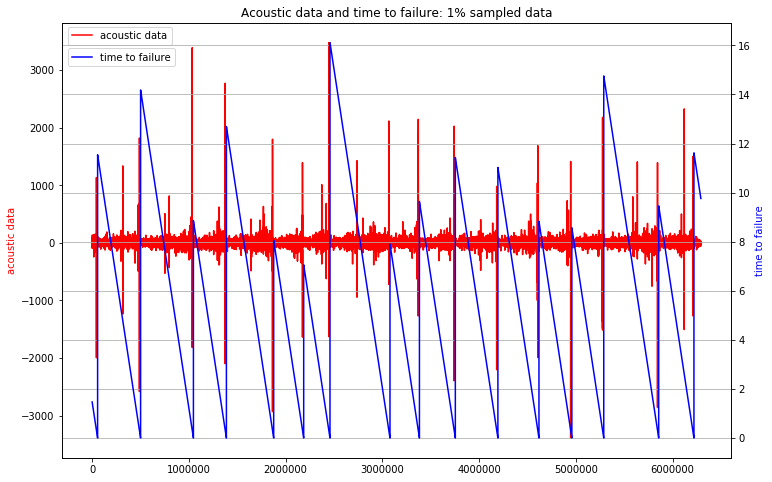

In [13]:
plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df)

In [14]:
del train_ad_sample_df
del train_ttf_sample_df

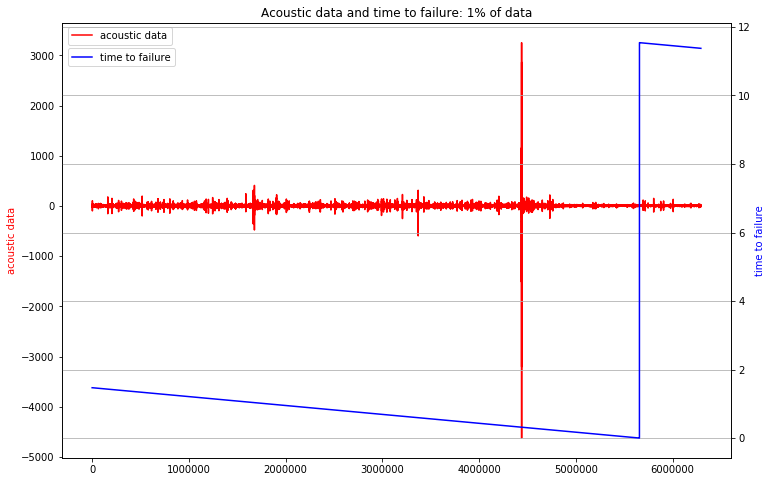

In [15]:
train_ad_sample_df = train_df['acoustic_data'].values[:6291455]
train_ttf_sample_df = train_df['time_to_failure'].values[:6291455]
plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data and time to failure: 1% of data")
del train_ad_sample_df
del train_ttf_sample_df

In [16]:
#feature Engineering
rows = 150000
segments = int(np.floor(train_df.shape[0] / rows))
print("Number of segments: ", segments)

Number of segments:  4194


In [17]:
def add_trend_feature(arr, abs_values=False):
    idx = np.array(range(len(arr)))
    if abs_values:
        arr = np.abs(arr)
    lr = LinearRegression()
    lr.fit(idx.reshape(-1, 1), arr)
    return lr.coef_[0]

def classic_sta_lta(x, length_sta, length_lta):
    sta = np.cumsum(x ** 2)
    # Convert to float
    sta = np.require(sta, dtype=np.float)
    # Copy for LTA
    lta = sta.copy()
    # Compute the STA and the LTA
    sta[length_sta:] = sta[length_sta:] - sta[:-length_sta]
    sta /= length_sta
    lta[length_lta:] = lta[length_lta:] - lta[:-length_lta]
    lta /= length_lta
    # Pad zeros
    sta[:length_lta - 1] = 0
    # Avoid division by zero by setting zero values to tiny float
    dtiny = np.finfo(0.0).tiny
    idx = lta < dtiny
    lta[idx] = dtiny
    return sta / lta

In [18]:
train_X = pd.DataFrame(index=range(segments), dtype=np.float64)
train_y = pd.DataFrame(index=range(segments), dtype=np.float64, columns=['time_to_failure'])


In [19]:
len(train_X)

4194

In [20]:
total_mean = train_df['acoustic_data'].mean()

In [21]:
total_std = train_df['acoustic_data'].std()

In [22]:
total_max = train_df['acoustic_data'].max()
total_min = train_df['acoustic_data'].min()


In [23]:
total_sum = train_df['acoustic_data'].sum()
total_abs_sum = np.abs(train_df['acoustic_data']).sum()

In [24]:
def create_features(seg_id, seg, X):
    xc = pd.Series(seg['acoustic_data'].values)
    zc = np.fft.fft(xc)
    
    X.loc[seg_id, 'mean'] = xc.mean()
    X.loc[seg_id, 'std'] = xc.std()
    X.loc[seg_id, 'max'] = xc.max()
    X.loc[seg_id, 'min'] = xc.min()
    
    #FFT transform values
    realFFT = np.real(zc)
    imagFFT = np.imag(zc)
    X.loc[seg_id, 'Rmean'] = realFFT.mean()
    X.loc[seg_id, 'Rstd'] = realFFT.std()
    X.loc[seg_id, 'Rmax'] = realFFT.max()
    X.loc[seg_id, 'Rmin'] = realFFT.min()
    X.loc[seg_id, 'Imean'] = imagFFT.mean()
    X.loc[seg_id, 'Istd'] = imagFFT.std()
    X.loc[seg_id, 'Imax'] = imagFFT.max()
    X.loc[seg_id, 'Imin'] = imagFFT.min()
    X.loc[seg_id, 'Rmean_last_5000'] = realFFT[-5000:].mean()
    X.loc[seg_id, 'Rstd__last_5000'] = realFFT[-5000:].std()
    X.loc[seg_id, 'Rmax_last_5000'] = realFFT[-5000:].max()
    X.loc[seg_id, 'Rmin_last_5000'] = realFFT[-5000:].min()
    X.loc[seg_id, 'Rmean_last_15000'] = realFFT[-15000:].mean()
    X.loc[seg_id, 'Rstd_last_15000'] = realFFT[-15000:].std()
    X.loc[seg_id, 'Rmax_last_15000'] = realFFT[-15000:].max()
    X.loc[seg_id, 'Rmin_last_15000'] = realFFT[-15000:].min()
    
    X.loc[seg_id, 'mean_change_abs'] = np.mean(np.diff(xc))
    X.loc[seg_id, 'mean_change_rate'] = np.mean(np.nonzero((np.diff(xc) / xc[:-1]))[0])
    X.loc[seg_id, 'abs_max'] = np.abs(xc).max()
    X.loc[seg_id, 'abs_min'] = np.abs(xc).min()
    
    X.loc[seg_id, 'std_first_50000'] = xc[:50000].std()
    X.loc[seg_id, 'std_last_50000'] = xc[-50000:].std()
    X.loc[seg_id, 'std_first_10000'] = xc[:10000].std()
    X.loc[seg_id, 'std_last_10000'] = xc[-10000:].std()
    
    X.loc[seg_id, 'avg_first_50000'] = xc[:50000].mean()
    X.loc[seg_id, 'avg_last_50000'] = xc[-50000:].mean()
    X.loc[seg_id, 'avg_first_10000'] = xc[:10000].mean()
    X.loc[seg_id, 'avg_last_10000'] = xc[-10000:].mean()
    
    X.loc[seg_id, 'min_first_50000'] = xc[:50000].min()
    X.loc[seg_id, 'min_last_50000'] = xc[-50000:].min()
    X.loc[seg_id, 'min_first_10000'] = xc[:10000].min()
    X.loc[seg_id, 'min_last_10000'] = xc[-10000:].min()
    
    X.loc[seg_id, 'max_first_50000'] = xc[:50000].max()
    X.loc[seg_id, 'max_last_50000'] = xc[-50000:].max()
    X.loc[seg_id, 'max_first_10000'] = xc[:10000].max()
    X.loc[seg_id, 'max_last_10000'] = xc[-10000:].max()
    
    X.loc[seg_id, 'max_to_min'] = xc.max() / np.abs(xc.min())
    X.loc[seg_id, 'max_to_min_diff'] = xc.max() - np.abs(xc.min())
    X.loc[seg_id, 'count_big'] = len(xc[np.abs(xc) > 500])
    X.loc[seg_id, 'sum'] = xc.sum()
    
    X.loc[seg_id, 'mean_change_rate_first_50000'] = np.mean(np.nonzero((np.diff(xc[:50000]) / xc[:50000][:-1]))[0])
    X.loc[seg_id, 'mean_change_rate_last_50000'] = np.mean(np.nonzero((np.diff(xc[-50000:]) / xc[-50000:][:-1]))[0])
    X.loc[seg_id, 'mean_change_rate_first_10000'] = np.mean(np.nonzero((np.diff(xc[:10000]) / xc[:10000][:-1]))[0])
    X.loc[seg_id, 'mean_change_rate_last_10000'] = np.mean(np.nonzero((np.diff(xc[-10000:]) / xc[-10000:][:-1]))[0])
    
    X.loc[seg_id, 'q95'] = np.quantile(xc, 0.95)
    X.loc[seg_id, 'q99'] = np.quantile(xc, 0.99)
    X.loc[seg_id, 'q05'] = np.quantile(xc, 0.05)
    X.loc[seg_id, 'q01'] = np.quantile(xc, 0.01)
    
    X.loc[seg_id, 'abs_q95'] = np.quantile(np.abs(xc), 0.95)
    X.loc[seg_id, 'abs_q99'] = np.quantile(np.abs(xc), 0.99)
    X.loc[seg_id, 'abs_q05'] = np.quantile(np.abs(xc), 0.05)
    X.loc[seg_id, 'abs_q01'] = np.quantile(np.abs(xc), 0.01)
    
    X.loc[seg_id, 'trend'] = add_trend_feature(xc)
    X.loc[seg_id, 'abs_trend'] = add_trend_feature(xc, abs_values=True)
    X.loc[seg_id, 'abs_mean'] = np.abs(xc).mean()
    X.loc[seg_id, 'abs_std'] = np.abs(xc).std()
    
    X.loc[seg_id, 'mad'] = xc.mad()
    X.loc[seg_id, 'kurt'] = xc.kurtosis()
    X.loc[seg_id, 'skew'] = xc.skew()
    X.loc[seg_id, 'med'] = xc.median()
    
    X.loc[seg_id, 'Hilbert_mean'] = np.abs(hilbert(xc)).mean()
    X.loc[seg_id, 'Hann_window_mean'] = (convolve(xc, hann(150), mode='same') / sum(hann(150))).mean()
    X.loc[seg_id, 'classic_sta_lta1_mean'] = classic_sta_lta(xc, 500, 10000).mean()
    X.loc[seg_id, 'classic_sta_lta2_mean'] = classic_sta_lta(xc, 5000, 100000).mean()
    X.loc[seg_id, 'classic_sta_lta3_mean'] = classic_sta_lta(xc, 3333, 6666).mean()
    X.loc[seg_id, 'classic_sta_lta4_mean'] = classic_sta_lta(xc, 10000, 25000).mean()
    X.loc[seg_id, 'Moving_average_700_mean'] = xc.rolling(window=700).mean().mean(skipna=True)
    X.loc[seg_id, 'Moving_average_1500_mean'] = xc.rolling(window=1500).mean().mean(skipna=True)
    X.loc[seg_id, 'Moving_average_3000_mean'] = xc.rolling(window=3000).mean().mean(skipna=True)
    X.loc[seg_id, 'Moving_average_6000_mean'] = xc.rolling(window=6000).mean().mean(skipna=True)
    ewma = pd.Series.ewm
    X.loc[seg_id, 'exp_Moving_average_300_mean'] = (ewma(xc, span=300).mean()).mean(skipna=True)
    X.loc[seg_id, 'exp_Moving_average_3000_mean'] = ewma(xc, span=3000).mean().mean(skipna=True)
    X.loc[seg_id, 'exp_Moving_average_30000_mean'] = ewma(xc, span=6000).mean().mean(skipna=True)
    no_of_std = 2
    X.loc[seg_id, 'MA_700MA_std_mean'] = xc.rolling(window=700).std().mean()
    X.loc[seg_id,'MA_700MA_BB_high_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] + no_of_std * X.loc[seg_id, 'MA_700MA_std_mean']).mean()
    X.loc[seg_id,'MA_700MA_BB_low_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] - no_of_std * X.loc[seg_id, 'MA_700MA_std_mean']).mean()
    X.loc[seg_id, 'MA_400MA_std_mean'] = xc.rolling(window=400).std().mean()
    X.loc[seg_id,'MA_400MA_BB_high_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] + no_of_std * X.loc[seg_id, 'MA_400MA_std_mean']).mean()
    X.loc[seg_id,'MA_400MA_BB_low_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] - no_of_std * X.loc[seg_id, 'MA_400MA_std_mean']).mean()
    X.loc[seg_id, 'MA_1000MA_std_mean'] = xc.rolling(window=1000).std().mean()
    
    X.loc[seg_id, 'iqr'] = np.subtract(*np.percentile(xc, [75, 25]))
    X.loc[seg_id, 'q999'] = np.quantile(xc,0.999)
    X.loc[seg_id, 'q001'] = np.quantile(xc,0.001)
    X.loc[seg_id, 'ave10'] = stats.trim_mean(xc, 0.1)
    
    for windows in [10, 100, 1000]:
        x_roll_std = xc.rolling(windows).std().dropna().values
        x_roll_mean = xc.rolling(windows).mean().dropna().values
        
        X.loc[seg_id, 'ave_roll_std_' + str(windows)] = x_roll_std.mean()
        X.loc[seg_id, 'std_roll_std_' + str(windows)] = x_roll_std.std()
        X.loc[seg_id, 'max_roll_std_' + str(windows)] = x_roll_std.max()
        X.loc[seg_id, 'min_roll_std_' + str(windows)] = x_roll_std.min()
        X.loc[seg_id, 'q01_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.01)
        X.loc[seg_id, 'q05_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.05)
        X.loc[seg_id, 'q95_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.95)
        X.loc[seg_id, 'q99_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.99)
        X.loc[seg_id, 'av_change_abs_roll_std_' + str(windows)] = np.mean(np.diff(x_roll_std))
        X.loc[seg_id, 'av_change_rate_roll_std_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_std) / x_roll_std[:-1]))[0])
        X.loc[seg_id, 'abs_max_roll_std_' + str(windows)] = np.abs(x_roll_std).max()
        
        X.loc[seg_id, 'ave_roll_mean_' + str(windows)] = x_roll_mean.mean()
        X.loc[seg_id, 'std_roll_mean_' + str(windows)] = x_roll_mean.std()
        X.loc[seg_id, 'max_roll_mean_' + str(windows)] = x_roll_mean.max()
        X.loc[seg_id, 'min_roll_mean_' + str(windows)] = x_roll_mean.min()
        X.loc[seg_id, 'q01_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.01)
        X.loc[seg_id, 'q05_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.05)
        X.loc[seg_id, 'q95_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.95)
        X.loc[seg_id, 'q99_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.99)
        X.loc[seg_id, 'av_change_abs_roll_mean_' + str(windows)] = np.mean(np.diff(x_roll_mean))
        X.loc[seg_id, 'av_change_rate_roll_mean_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_mean) / x_roll_mean[:-1]))[0])
        X.loc[seg_id, 'abs_max_roll_mean_' + str(windows)] = np.abs(x_roll_mean).max()

In [25]:
# iterate over all segments
for seg_id in tqdm_notebook(range(segments)):
    seg = train_df.iloc[seg_id*rows:seg_id*rows+rows]
    create_features(seg_id, seg, train_X)
    train_y.loc[seg_id, 'time_to_failure'] = seg['time_to_failure'].values[-1]

In [26]:
train_X.shape

(4194, 154)

In [27]:
train_X.head(10)

,mean,std,max,min,Rmean,Rstd,Rmax,Rmin,Imean,Istd,...,std_roll_mean_1000,max_roll_mean_1000,min_roll_mean_1000,q01_roll_mean_1000,q05_roll_mean_1000,q95_roll_mean_1000,q99_roll_mean_1000,av_change_abs_roll_mean_1000,av_change_rate_roll_mean_1000,abs_max_roll_mean_1000
0,4.884113333333334,5.101106130606765,104.0,-98.0,11.999999999999998,2349.811481800189085,732617.0,-20121.154171234855312,-1.697723443309466e-15,1399.854635310395452,...,0.295714650592636,5.629,3.896,4.072,4.379,5.338,5.484,-0.000001704697987,74222.343442640820285,5.629
1,4.725766666666667,6.588823781946801,181.0,-154.0,4.999999999999999,2566.032248433366476,708865.0,-31056.675076437575626,1.843242595593135e-15,1810.312265881220810,...,0.231586699576737,5.667,3.412,4.233,4.345,5.066,5.223,-0.000002449664430,74364.426477527638781,5.667
2,4.906393333333333,6.967397033524431,140.0,-106.0,4.999999999999996,2683.549049300198476,735959.0,-27654.557067499525147,4.850638409455618e-16,1921.220575571685913,...,0.267011771793293,5.957,4.055,4.239,4.446,5.344,5.486,0.000001140939597,74594.984584474615986,5.957
3,4.902240000000000,6.922305187180113,197.0,-199.0,5.000000000000003,2685.788524809800037,735336.0,-25622.393603785181767,-1.067140450080236e-15,1891.826366239777371,...,0.266699817775971,5.858,3.722,4.304,4.433,5.317,5.453,-0.000002550335570,74333.143622613599291,5.858
4,4.908720000000000,7.301110189758817,145.0,-126.0,12.000000000000000,2761.715771037997456,736308.0,-26271.075116963391338,-1.455191522836685e-16,1995.742969422665965,...,0.228004751350508,6.078,3.918,4.434,4.543,5.306,5.491,0.000001550335570,74428.435968884237809,6.078
5,4.913513333333333,5.434111112860393,142.0,-144.0,14.000000000000000,2420.968091487370657,737027.0,-24168.435450134638813,3.880510727564494e-16,1479.700814354036993,...,0.293941260517808,5.838,4.042,4.270,4.422,5.402,5.620,-0.000003697986577,74539.909434154062183,5.838
6,4.855660000000000,5.687823395051908,120.0,-78.0,-0.000000000000004,2437.523640910996164,728349.0,-23876.893136299157050,-5.820766091346741e-16,1564.532358246386821,...,0.219471906215868,5.546,3.958,4.285,4.504,5.214,5.370,-0.000000114093960,74501.904750525020063,5.546
7,4.505426666666667,5.854511569720713,139.0,-134.0,3.000000000000002,2361.259303846149123,675814.0,-25427.499452212759934,-1.333925562600295e-16,1615.715785650434100,...,0.218514054888406,5.180,3.489,4.040,4.148,4.863,4.953,-0.000001395973154,74515.926219409957412,5.180
8,4.717833333333333,7.789643113079984,168.0,-156.0,1.000000000000002,2805.303459520912384,707675.0,-34542.227581035360345,-8.609883176783720e-16,2137.915924446047939,...,0.240916531351268,5.717,3.933,4.158,4.315,5.104,5.337,0.000002221476510,74464.251034999178955,5.717
9,4.730960000000000,6.890459152667711,152.0,-126.0,5.000000000000003,2620.173753780462448,709644.0,-23173.271871617391298,4.850638409455618e-16,1900.967779842677828,...,0.258462298074467,5.423,3.832,4.190,4.301,5.128,5.261,0.000005127516779,74344.216474791013752,5.423


In [28]:
scaler = StandardScaler()
scaler.fit(train_X)
scaled_train_X = pd.DataFrame(scaler.transform(train_X), columns=train_X.columns)


In [29]:
scaled_train_X.head(10)

,mean,std,max,min,Rmean,Rstd,Rmax,Rmin,Imean,Istd,...,std_roll_mean_1000,max_roll_mean_1000,min_roll_mean_1000,q01_roll_mean_1000,q05_roll_mean_1000,q95_roll_mean_1000,q99_roll_mean_1000,av_change_abs_roll_mean_1000,av_change_rate_roll_mean_1000,abs_max_roll_mean_1000
0,1.424140499795022,-0.170213582943171,-0.218193508692627,0.193218185209325,1.199316205489369,-0.105006593381723,1.424140499795018,0.156736086729651,-0.817054171549973,-0.169052005333305,...,0.268470130890001,-0.004741890462161,0.178277723969481,0.287332145975991,0.965402446610929,1.509153430549683,0.885262121712506,-0.631300343511894,-1.832422175860377,-0.004741890462161
1,0.805716032556442,0.004734017014316,0.063936007992510,-0.018037271219829,0.078885810556771,-0.008598597346281,0.805716032556438,-0.222117948425052,0.905933851576364,0.007211752080005,...,-0.141264321988320,0.007341389309125,-0.025386948237320,0.622391465890732,0.842747052156309,0.522427542165818,0.294356817530996,-0.912053970881953,-0.890022480697742,0.007341389309125
2,1.511155259373638,0.049252196732055,-0.086288799593083,0.163038834290874,0.078885810556770,0.043799511533280,1.511155259373636,-0.104253774698728,0.245061733116947,0.054839360725539,...,0.085078050610279,0.099555892826834,0.245184093558079,0.634878148620475,1.207105723918564,1.530919442793446,0.889790131706233,0.441127926802558,0.639209280695772,0.099555892826834
3,1.494934375107487,0.043949637951170,0.122560323147863,-0.187796120136112,0.078885810556771,0.044798043493984,1.494934375107485,-0.033850788412464,-0.510220687979529,0.042216538302113,...,0.083084874365199,0.068075769212167,0.105059432721582,0.770150544859347,1.160208073097680,1.432972387696517,0.815077966809722,-0.949993650256284,-1.097513494373596,0.068075769212167
4,1.520242078970568,0.088495070341074,-0.067968701107035,0.087590456994748,1.199316205489369,0.078652301654897,1.520242078970566,-0.056323939067857,-0.061771750453496,0.086841682459309,...,-0.164150560726067,0.138031599466982,0.187535209069790,1.040695337337088,1.557034349274394,1.393068031916287,0.901110156690553,0.595415956258175,-0.465464227208672,0.138031599466982
5,1.538962489544185,-0.131053986788160,-0.078960760198664,0.019686917428235,1.519439175470111,-0.073279455182016,1.538962489544182,0.016520649604222,0.197856581798417,-0.134763478369498,...,0.257139361692816,0.061716148279912,0.239713761453351,0.699392676057474,1.120525445480008,1.741324227816475,1.193166801286013,-1.382505995123670,0.273910179965897,0.061716148279912
6,1.313015726042317,-0.101218785996422,-0.159569193537274,0.268666562505451,-0.721421614395086,-0.065897706573636,1.313015726042313,0.026620944137275,-0.274194931386880,-0.098334074796606,...,-0.218669699063587,-0.031134317331023,0.204367000161261,0.730609382881830,1.416341396811739,1.059322510845276,0.627165552070007,-0.031853409397449,0.021835030421887,-0.031134317331023
7,-0.054824008985421,-0.081617152532347,-0.089952819290292,0.057411106076298,-0.241237159423971,-0.099902265987057,-0.054824008985424,-0.027098806829572,-0.055871106538680,-0.076354258709420,...,-0.224789724471834,-0.147515380391304,0.007014249613762,0.220736504750701,0.132067266639831,-0.213989205414785,-0.316924531622290,-0.514951993430610,0.114835774764259,-0.147515380391304
8,0.774732321036825,0.145943916470089,0.016303751928785,-0.025582108949441,-0.561360129404713,0.098087075492250,0.774732321036822,-0.342872656184990,-0.409909741427653,0.147895339130580,...,-0.081652975344229,0.023240441639764,0.193847130729092,0.466307931768960,0.734521704108117,0.660278953042976,0.552453387173494,0.848347152087057,-0.227912239275442,0.023240441639764
9,0.825998647072221,0.040204715451199,-0.042320563226568,0.087590456994748,0.078885810556771,0.015541887002806,0.825998647072220,0.050997446880598,0.245061733116947,0.046142156416401,...,0.030452666809819,-0.070245986064396,0.151346858223127,0.532903572994250,0.684016541685625,0.747343002018023,0.380389007411829,1.943539230026109,-1.024070155238219,-0.070245986064396


In [30]:
submission = pd.read_csv(path+'\\sample_submission.csv', index_col='seg_id')
test_X = pd.DataFrame(columns=train_X.columns, dtype=np.float64, index=submission.index)

In [31]:
submission.shape, test_X.shape

((2624, 1), (2624, 154))

In [34]:
for seg_id in tqdm_notebook(test_X.index):
    seg = pd.read_csv(path+'\\test\\' + seg_id + '.csv')
    create_features(seg_id, seg, test_X)

In [35]:
scaled_test_X = pd.DataFrame(scaler.transform(test_X), columns=test_X.columns)

In [36]:
scaled_test_X.shape

(2624, 154)

In [37]:
scaled_test_X.tail(10)

,mean,std,max,min,Rmean,Rstd,Rmax,Rmin,Imean,Istd,...,std_roll_mean_1000,max_roll_mean_1000,min_roll_mean_1000,q01_roll_mean_1000,q05_roll_mean_1000,q95_roll_mean_1000,q99_roll_mean_1000,av_change_abs_roll_mean_1000,av_change_rate_roll_mean_1000,abs_max_roll_mean_1000
2614,-1.081634623438432,-0.268601942296902,-0.350098217792172,0.329025264342352,-0.081175674433600,-0.256057804503499,-1.081634623438434,0.296094951842351,-0.746246444572178,-0.265116961140863,...,-0.131863367972886,-0.197756385756125,0.067608697543058,-0.245432983826332,-0.755380587355362,-0.834320554361995,-0.568229086274198,-0.621183095678739,-0.332742633283314,-0.197756385756125
2615,-0.734695164615844,-0.320940103312901,-0.390402434461477,0.400701222773672,0.559070265527884,-0.271490841421192,-0.734695164615847,0.457524666141680,0.056241127842828,-0.320648190853422,...,-0.090273729721340,-0.210475627620636,-0.012763104918716,-0.420246542042718,-0.632725192900742,-0.772650186338005,-0.620301201202069,0.066789756975814,0.379958267345616,-0.210475627620636
2616,-2.073321685925087,0.185999424044961,0.045615909506462,0.027231755157847,0.238947295547142,0.058192651768876,-2.073321685925090,-0.198272835507732,-0.274194931386880,0.182882262889467,...,-0.335397473385972,-0.255310955193040,-0.100709213371653,-0.919713851232396,-1.650043464553771,-2.114887608036642,-1.421758970091934,-0.681886582677671,-0.455029743769391,-0.255310955193040
2617,-0.427930383839279,-0.291596382506079,-0.196209390509370,0.310163170018320,0.238947295547142,-0.242327244436703,-0.427930383839283,0.412107554533329,0.363074611413272,-0.293675558394082,...,-0.306297807314964,-0.147833361437917,0.084019693857243,-0.076862766974816,-0.026663243830852,-0.547734726485800,-0.409748736493715,0.491714165968333,0.259853681784336,-0.147833361437917
2618,-3.374741716678421,-0.152003490043633,-0.298801942031238,0.234714792722194,-0.721421614395085,-0.249113638779983,-3.374741716678424,0.271951919845560,0.009035976524298,-0.156716904848106,...,-0.176297932752017,-0.424476871991044,-0.208011881579782,-1.854133942174751,-3.157983314025280,-3.239464907297666,-2.157560594072741,-0.466895066223123,-0.517982573703920,-0.424476871991044
2619,-1.654729139621841,-0.172408272635962,-0.339106158700543,0.374294290720027,-1.041544584375827,-0.215590231150948,-1.654729139621846,0.224509483145720,0.127048854820623,-0.166937482945480,...,-0.035382823436088,-0.240683827048852,-0.014025489250577,-0.663736855272686,-1.487705442481479,-1.469162578138378,-0.817269635929239,0.643472883465663,-0.554972820552376,-0.240683827048852
2620,-1.487885758598570,-0.060792925011241,0.001647673139947,-0.221747889919369,0.238947295547142,-0.124402235161050,-1.487885758598571,0.230258375488919,0.103446279161358,-0.063658336471214,...,0.301725399442915,-0.128754498641149,-0.147417433650486,-1.354666632985074,-2.028832182722451,-1.425630553650856,-0.894245805822615,1.559083812366209,-0.820948539836463,-0.128754498641149
2621,-3.010670087956753,0.343254632011228,0.536594548932544,-0.580127682075968,-0.241237159423972,0.174257853534564,-3.010670087956756,-0.487617919728305,0.787920973280040,0.340983182941972,...,-0.166314501054057,-0.130344403874213,-0.335933493874962,-1.564859125602396,-2.624071596987521,-2.956506748128763,-1.935688104380066,1.604611427615407,-0.954385032173800,-0.130344403874213
2622,-0.694312192710866,0.782096807867043,0.727123573187442,-0.640486383912869,-0.241237159423971,0.628381731544477,-0.694312192710869,-1.113687307556833,1.401587940420927,0.778366527088963,...,-0.045220121607113,0.055356527347656,-0.178977041946994,-0.303704169898461,-0.679622843721626,-0.761767180216124,0.006828182929265,0.916638574960853,1.362109444329824,0.055356527347656
2623,-1.248764408517769,-0.349888468230894,-0.331778119306124,0.347887358666383,0.238947295547142,-0.306138783032271,-1.248764408517773,0.388179518203963,0.073943059587277,-0.350400284361961,...,-0.256027867555159,-0.247997391120946,0.047831343010580,-0.497247752209461,-0.97183128

In [38]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)
train_columns = scaled_train_X.columns.values

In [39]:
params = {'num_leaves': 51,
         'min_data_in_leaf': 10, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.001,
         "boosting": "gbdt",
         "feature_fraction": 0.91,
         "bagging_freq": 1,
         "bagging_fraction": 0.91,
         "bagging_seed": 42,
         "metric": 'mae',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": -1,
         "random_state": 42}

In [40]:
oof = np.zeros(len(scaled_train_X))
predictions = np.zeros(len(scaled_test_X))
feature_importance_df = pd.DataFrame()
#run model
for fold_, (trn_idx, val_idx) in enumerate(folds.split(scaled_train_X,train_y.values)):
    strLog = "fold {}".format(fold_)
    print(strLog)
    
    X_tr, X_val = scaled_train_X.iloc[trn_idx], scaled_train_X.iloc[val_idx]
    y_tr, y_val = train_y.iloc[trn_idx], train_y.iloc[val_idx]

    model = lgb.LGBMRegressor(**params, n_estimators = 20000, n_jobs = -1)
    model.fit(X_tr, y_tr, 
                    eval_set=[(X_tr, y_tr), (X_val, y_val)], eval_metric='mae',
                    verbose=1000, early_stopping_rounds=200)
    oof[val_idx] = model.predict(X_val, num_iteration=model.best_iteration_)
    #feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = model.feature_importances_[:len(train_columns)]
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    #predictions
    predictions += model.predict(scaled_test_X, num_iteration=model.best_iteration_) / folds.n_splits

fold 0
Training until validation scores don't improve for 200 rounds.
[1000]	training's l1: 1.95634	valid_1's l1: 2.25603
[2000]	training's l1: 1.56447	valid_1's l1: 2.12924
[3000]	training's l1: 1.33494	valid_1's l1: 2.10795
Early stopping, best iteration is:
[3752]	training's l1: 1.20007	valid_1's l1: 2.10534
fold 1
Training until validation scores don't improve for 200 rounds.
[1000]	training's l1: 1.9498	valid_1's l1: 2.27346
[2000]	training's l1: 1.55889	valid_1's l1: 2.1434
[3000]	training's l1: 1.33356	valid_1's l1: 2.12134
[4000]	training's l1: 1.15941	valid_1's l1: 2.11821
Early stopping, best iteration is:
[4300]	training's l1: 1.11344	valid_1's l1: 2.11736
fold 2
Training until validation scores don't improve for 200 rounds.
[1000]	training's l1: 1.95765	valid_1's l1: 2.28079
[2000]	training's l1: 1.57167	valid_1's l1: 2.11825
[3000]	training's l1: 1.34383	valid_1's l1: 2.08514
[4000]	training's l1: 1.16729	valid_1's l1: 2.07764
Early stopping, best iteration is:
[4398]	trai

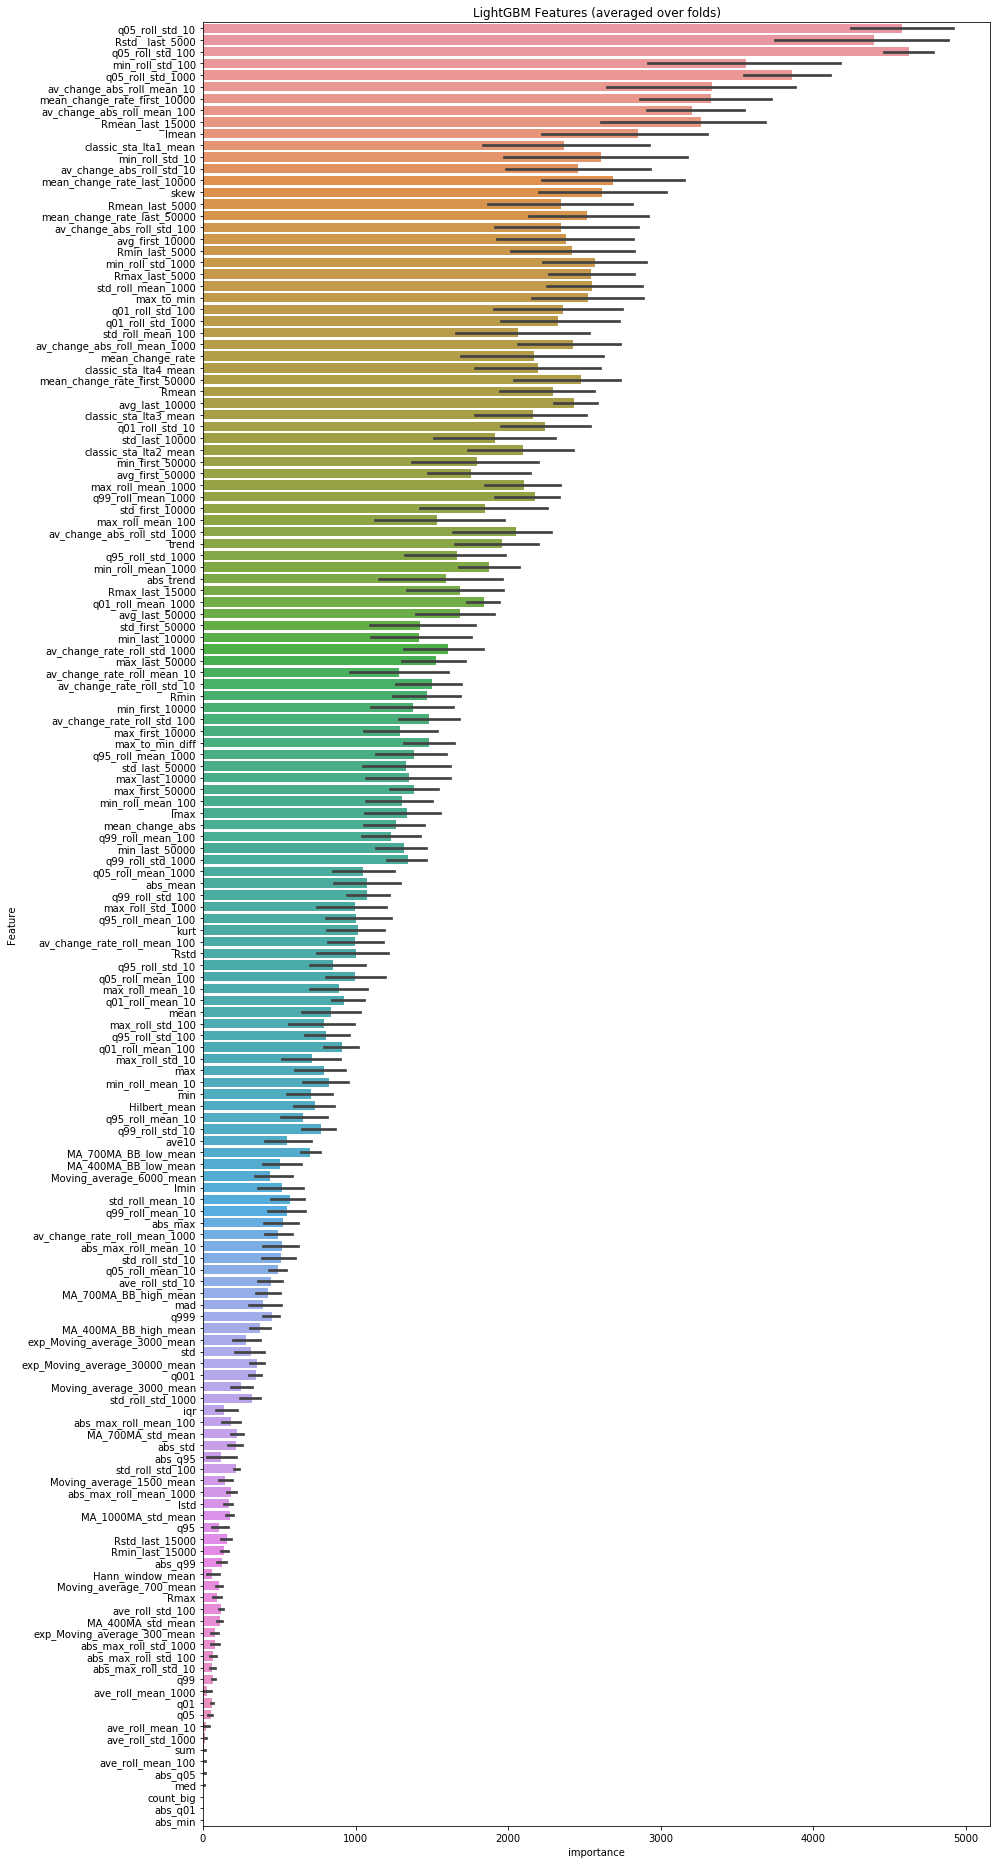

In [41]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:200].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')


In [42]:
submission.time_to_failure = predictions
submission.to_csv(path+'\\submission.csv',index=True)

In [43]:
#earthquakes-fe-more-features-and-samples


In [55]:
print('{0} samples in new train data and {1} columns.'.format(X_tr.shape[0],X_tr.shape[1]))

3356 samples in new train data and 154 columns.


In [46]:
np.abs(X_tr.corrwith(y_tr['time_to_failure'])).sort_values(ascending=False).head(12)

q05_roll_std_100     0.646534365218238
q01_roll_std_100     0.642393660173992
q05_roll_std_10      0.639777629432079
q01_roll_std_10      0.634421907924836
q05_roll_std_1000    0.610571818046043
q01_roll_std_1000    0.599711104651425
min_roll_std_1000    0.536632471553112
iqr                  0.497355493308337
q95_roll_std_10      0.423808744447611
q95_roll_mean_10     0.421988134645084
q95_roll_std_100     0.417568865176154
q05_roll_mean_10     0.413307349508978
dtype: float64

NameError: name 'ax1' is not defined

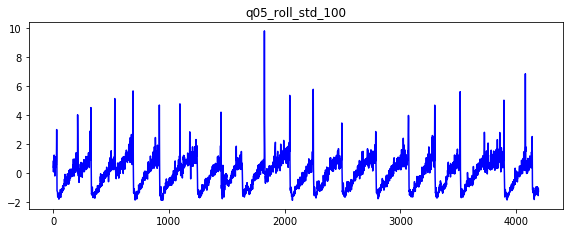

In [47]:
plt.figure(figsize=(44, 24))
cols = list(np.abs(X_tr.corrwith(y_tr['time_to_failure'])).sort_values(ascending=False).head(24).index)
for i, col in enumerate(cols):
    plt.subplot(6, 4, i + 1)
    plt.plot(X_tr[col], color='blue')
    plt.title(col)
    ax1.set_ylabel(col, color='b')

    ax2 = ax1.twinx()
    plt.plot(y_tr, color='g')
    ax2.set_ylabel('time_to_failure', color='g')
    plt.legend([col, 'time_to_failure'], loc=(0.875, 0.9))
    plt.grid(False)

In [48]:
means_dict = {}
for col in X_tr.columns:
    if X_tr[col].isnull().any():
        print(col)
        mean_value = X_tr.loc[X_tr[col] != -np.inf, col].mean()
        X_tr.loc[X_tr[col] == -np.inf, col] = mean_value
        X_tr[col] = X_tr[col].fillna(mean_value)
        means_dict[col] = mean_value

In [49]:
scaler = StandardScaler()
scaler.fit(X_tr)
X_train_scaled = pd.DataFrame(scaler.transform(X_tr), columns=X_tr.columns)

In [50]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)

In [57]:
def train_model(X=X_train_scaled, X_test=X_test_scaled, y=y_tr, params=None, folds=folds, model_type='lgb', plot_feature_importance=False, model=None):

    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        
        if model_type == 'lgb':
            model = lgb.LGBMRegressor(**params, n_estimators = 50000, n_jobs = -1)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='mae',
                    verbose=10000, early_stopping_rounds=200)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = mean_absolute_error(y_valid, y_pred_valid)
            print('Fold {0}. MAE: {score:.4f}.'.format(fold_n))
            print('')
            
            y_pred = model.predict(X_test).reshape(-1,)
        
        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000,  eval_metric='MAE', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(mean_absolute_error(y_valid, y_pred_valid))

        prediction += y_pred    
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        return oof, prediction
    
    else:
        return oof, prediction

NameError: name 'X_test_scaled' is not defined